In [ ]:
#hide
from nbdev import *
from utilities.ipynb_docgen import *

# The `wtlike` package

> Code for generating fermi-LAT light curves.

### GitHub Links

- [this document](https://tburnett.github.io/wtlike/)
-  [repository](https://github.com/tburnett/wtlike)

## Context

This package has code that was adapted to the [nbdev](https://nbdev.fast.ai/) code/tests/documentation environment from the [github package lat-timing](https://github.com/tburnett/lat-timing) to manage light curves of Fermi-LAT sources.  
It is based on a [paper](https://arxiv.org/pdf/1910.00140.pdf) by Matthew Kerr, which derives the [weighted likelihood formalism](https://tburnett.github.io/wtlike/loglike#The-Kerr-likelihood-formula) used here, specifically with
the [Bayesian Block](https://arxiv.org/pdf/1207.5578.pdf) to detect and characterize variability of a gamma-ray source.

Also, I've ported some code from  my [jupydoc](https://github.com/tburnett/jupydoc) documentation package supporting enhanced documentation combining Markdown and code, such that the 
Markdown reflects execution of the code.

## Installation
Istall from pip:

```
pip install wtlike
```

## Demo

The following code cell loads the data for the BL Lac blazar, and plots by default, a weekly light curve for the full *fermi* mission

SourceData: photons and exposure for BL Lac: Restoring from cache with key "BL Lac_data"
WtLike: Source BL Lac with:
	 data:       310,969 photons from   2008-08-04 to 2021-05-06
	 exposure: 3,177,752 intervals from 2008-08-04 to 2021-05-06
CellData: Bin photon data into 665 1-week bins from 54683.0 to 59338.0
LightCurve: select 656 cells for fitting with e>0.5 & n>2


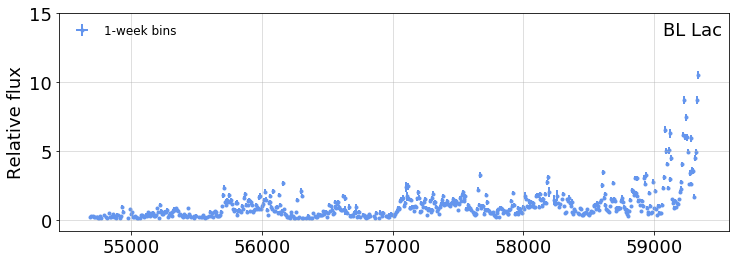

In [ ]:
from wtlike import *
weekly = WtLike('BL Lac') # how to define 7-day bins for the full dataset.
weekly.plot(ylim=(-0.8,15)); #plot takes plt.plot args.

The variable `weekly` has lots of capabilities.
To examine a subset of the data at the end of the current data, we use `view` to create a new `WtLike` object and plot it.

In [ ]:
len(weekly.cells)

665

CellData: Bin photon data into 120 1-hour bins from 59335.0 to 59340.0
LightCurve: select 81 cells for fitting with e>0.5 & n>2


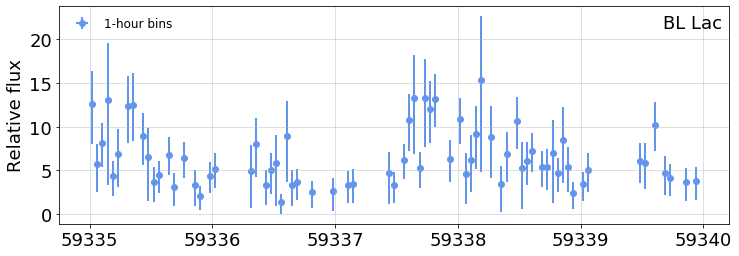

In [ ]:
hourly_at_end = weekly.view((-5,0, 1/24)) # for the last 5 days, 1-hour bins
hourly_at_end.plot(); # Accepts plt.plot args, e.g. xlim, ylim, etc.

Or, to do a Bayesian Block partition with these 1-hour bins, perform fits, and overplot the result, just run the following.

Partitioned 81 cells into 4 blocks, using LikelihoodFitness 
LightCurve: Loaded 4 / 4 cells for fitting


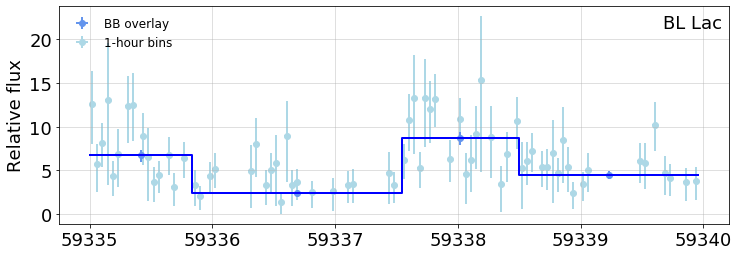

In [ ]:
hourly_at_end.plot_BB(fmt='o');

Finally, let's look at the values plotted above:

In [ ]:
hourly_at_end.bb_table()

,t,tw,n,flux,ts,errors,limit
0,59335.42,0.83,178,6.70,404.1,"(-0.655, 0.689)",7.89
1,59336.69,1.71,205,2.38,170.0,"(-0.308, 0.323)",2.93
2,59338.02,0.96,222,8.70,573.6,"(-0.734, 0.767)",10.01
3,59339.23,1.46,217,4.48,369.4,"(-0.434, 0.454)",5.25


## Input data

There are three data sources which `wtlike` needs to function:


-	The photon/spacecraft data
-	A table of weights for each source
-	An effective area IRF table 

These must be found under a folder, which by default is `~/wtlike_data`. In that folder there must be (perhaps links to) three folders named `data_files`, `weight_files`, `aeff_files`.  A copy of what I'm using is at `/afs/slac/g/glast/users/burnett/wtlike_data`

## Module summary

### Configuration [config](https://tburnett.github.io/wtlike/config)
Implements basic configuration information, [Config](https://tburnett.github.io/wtlike/config#Config), a cache system [Cache](https://tburnett.github.io/wtlike/config#Cache), point source info [PointSource](https://tburnett.github.io/wtlike/config#PointSource), and [time conversion](https://tburnett.github.io/wtlike/config#Time-conversion)

### Photon and Spacecraft Data  [data_man](https://tburnett.github.io/wtlike/data_man)
This module manages conversion of the weekly FT1 (photons) and FT2 (spacecraft) files, downloaded from  [GSFC](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly), to a folder containing  pickled files, each with tables of photons, space craft data, and a list of GTI times derived from the FT1 file. The total size of this is 2.8 GB. A class [WeeklyData](https://tburnett.github.io/wtlike/data_man#WeeklyData) exports the results.

### Source data  [source_data](https://tburnett.github.io/wtlike/source_data)
The module depends on a specific source. It extracts the photons within a disk, and calculates the exposure for this direction. It assumes that a weigtht analysis has been done for this source, which it uses to apply a weight to each photon. This is handled by the class [SourceData](https://tburnett.github.io/wtlike/source_data#SourceData). 

### Cell data [cell_data](https://tburnett.github.io/wtlike/cell_data)
The next step is to define a set of time bins. This module, implementing the class [CellData(SourceData)](https://tburnett.github.io/wtlike/cell_data#CellData), creates a set of cells.

### The light-curve  [light_curve](https://tburnett.github.io/wtlike/lightcurve)
The the class [LightCurve(CellData)](https://tburnett.github.io/wtlike/lightcurve#LightCurve) uses the set of cell defined by its super class, and evaluates the likelihood for each. This function is represented by a Poisson-like function for further analysis. It creates a table with this information for plotting a light curve.

### Bayesian Blocks [bayesian](https://tburnett.github.io/wtlike/bayesian) 
THis module defines the class [BBanalysis(LightCurve)](https://tburnett.github.io/wtlike/bayesian#BBanalysis). INheriting from `LightCurve`, it adds Bayesian block capability. It is the class returned by `from wtlike import WtLike'

### Simulation [simulation](https://tburnett.github.io/wtlike/simulation)
A light curve can be also generated with a simulation.